# Logit Regression and ROC Curve

In [1]:
import pandas as pd
import numpy as np

### Data
-features to predict a heart disease
- data and info can be found here: https://web.stanford.edu/~hastie/ElemStatLearn/

In [2]:
data=pd.read_csv('heart.txt', index_col=0)
data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
row.names,,,,,,,,,,
1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


### Preparing Data

In [3]:
data['famhist']=data['famhist'].replace('Present',1)
data['famhist']=data['famhist'].replace('Absent',0)

### Spliting the Data

In [4]:
import random
target='chd'
features=data.columns.drop(labels='chd')
i_test=random.sample(range(0,463),92)
i_train=[]
for i in data.index:
    if i not in i_test:
        i_train.append(i)
X_train=data.loc[i_train, features]
y_train=data.loc[i_train, target]
X_test=data.loc[i_test, features]
y_test=data.loc[i_test, target]

### Standarizing and adding bias term

In [5]:
mean=np.mean(X_train)
std=np.std(X_train)
X_train-=mean
X_train/=std
X_test-=mean
X_test/=mean
X_train.insert(0,'bias',1)
X_test.insert(0,'bias',1)

### Turning the data into Numpy arrays

In [6]:
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array([y_train]).T
y_test=np.array([y_test]).T

### Sigmoid Activation Function
$z=XW$\
$sigmoid=\dfrac{1}{1+e^{(-z)}}$
### Cost Function
$errors=Y-sigmoid$
### Derivatives from errors
$\delta= X^{T}*errors$ 
### Weight Updates
$W_{i}=W_{i-1}-(\alpha*\delta)$

### Training the Model

In [7]:
weights=np.zeros([X_train.shape[1],1])
epochs=1000
MSE=[]
alpha=.001
for epoch in range(epochs):
    z=np.dot(X_train,weights)
    sigmoid=1/(1+np.exp(-z))
    errors=y_train-sigmoid
    mse=np.sum((errors**2))/len(X_train)
    MSE.append(mse)
    gradient=np.dot(X_train.T, errors)
    weights += alpha*gradient

### sklearn reference

In [8]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(fit_intercept=False) # bias term already added in the data
clf.fit(X_train,y_train)

C:\Users\jesse\miniconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(fit_intercept=False)

### Weight Comparision

In [9]:
table=pd.DataFrame()
table['my weights']=weights.ravel()
table['sklearn weights']=clf.coef_.ravel()
table

,my weights,sklearn weights
0,-0.963350,-0.938068
1,0.146384,0.145552
2,0.344999,0.341963
3,0.361813,0.353924
4,0.182158,0.174945
5,0.423607,0.416169
6,0.347043,0.334877
7,-0.308143,-0.292311
8,-0.069962,-0.068841
9,0.657932,0.637297


### Accuracy

In [10]:
my_z=np.dot(X_test,weights)                                        # predictions and probabilities with test set
my_prob=1/(1+np.exp(-my_z))
my_predict=[1 if p>.5 else 0 for p in my_prob]
sk_prob = list(clf.predict_proba(X_test)[:,1])
sk_predict=clf.predict(X_test)

y=y_test.ravel()                                                   # getting accuracy
y=y.tolist()                                                       
my_accuracy=sum(p==a for p,a in zip(my_predict,y))/len(y)
sk=sk_predict.tolist()
sk_accuracy=sum(p==a for p,a in zip(sk_predict,y))/len(y)
print('my accuracy score:', my_accuracy)
print('sk accuracy score:', sk_accuracy)

my accuracy score: 0.7065217391304348
sk accuracy score: 0.7065217391304348


- Even with slightly different weights the predictions on the test set are identical

In [11]:
sk_predict==my_predict

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

### ROC Curve
$TPR=\dfrac{TP}{TP+FN}$\
$FPR=\dfrac{FP}{FP+TN}$

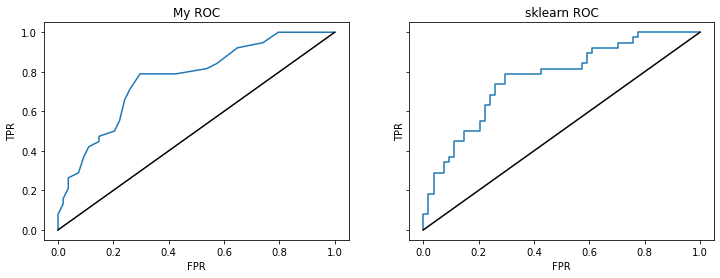

My AUC: 0.7685185185185186
sklearn AUC 0.7680311890838207


In [141]:
y=y_test.ravel()
y=y.tolist()
prob=my_prob.ravel()
prob=prob.tolist()
tpr=[]
fpr=[]
for thresh in np.linspace(0,1,40):               # my ROC curve
    tn=tp=fn=fp=0
    for real,p in zip(y,prob):
        if p>thresh:
            if real==1:
                tp+=1
            else:
                fp+=1              
        else:
            if real==0:
                tn+=1
            else:
                fn+=1
    tpr.append(tp/(tp+fn))
    fpr.append(fp/(fp+tn))
        
from sklearn.metrics import roc_curve, roc_auc_score     #sklearn ROC curve
sk_fpr, sk_tpr, _ = roc_curve(y, prob)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, sharex=False, sharey=True,figsize=(12,4))
ax[0].plot(fpr,tpr)
ax[0].plot([0,1],[0,1],c='k')
ax[0].title.set_text('My ROC')
ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')
ax[1].plot(sk_fpr,sk_tpr)
ax[1].plot([0,1],[0,1],c='k')
ax[1].title.set_text('sklearn ROC')
ax[1].set_xlabel('FPR')
ax[1].set_ylabel('TPR')
plt.show()
print('My AUC:', roc_auc_score(y,prob))
print('sklearn AUC',roc_auc_score(y,sk_prob))